In [62]:
import json
import pandas as pd

In [63]:
with open("user-wallet-transactions.json", "r") as file:
    data = json.load(file)

In [64]:
df = pd.json_normalize(data)

In [65]:
print("Total Records:", len(df))
print(df.columns)
print(df.head())

Total Records: 100000
Index(['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp',
       'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type',
       'actionData.amount', 'actionData.assetSymbol',
       'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId',
       'createdAt.$date', 'updatedAt.$date', 'actionData.toId',
       'actionData.borrowRateMode', 'actionData.borrowRate',
       'actionData.variableTokenDebt', 'actionData.stableTokenDebt',
       'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId',
       'actionData.liquidatorId', 'actionData.collateralAmount',
       'actionData.collateralAssetPriceUSD', 'actionData.principalAmount',
       'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId',
       'actionData.collateralReserveSymbol', 'actionData.principalReserveId',
       'actionData.principalReserveSymbol'],
      dtype='object')
                                   userWallet  network protocol  \
0

In [66]:
df['action'].value_counts()

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

In [67]:
df = pd.DataFrame(data)

In [68]:
print("Columns:", df.columns)
print("Sample Row:\n", df.iloc[0])

Columns: Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')
Sample Row:
 _id                         {'$oid': '681d38fed63812d4655f571a'}
userWallet            0x00000000001accfa9cef68cf5371a23025b6d4b6
network                                                  polygon
protocol                                                 aave_v2
txHash         0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...
logId          0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...
timestamp                                             1629178166
blockNumber                                           1629178166
action                                                   deposit
actionData     {'type': 'Deposit', 'amount': '2000000000', 'a...
__v                                                            0
createdAt                  {'$date': '2025-05-08T23:06:39.465Z'}
update

In [69]:
action_df = pd.json_normalize(df['actionData'])

In [70]:
df = df.join(action_df).drop(columns=['actionData'])

In [71]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce') / 1e18  

In [72]:
df.dropna(subset=['userWallet', 'amount', 'action'], inplace=True)

In [73]:
df['action'] = df['action'].str.lower()

In [74]:
wallets = df['userWallet'].unique()
features = []

In [75]:
from tqdm import tqdm


In [76]:
for wallet in tqdm(wallets):
    wdf = df[df['userWallet'] == wallet]

    f = {
        'wallet_address': wallet,
        'num_deposits': len(wdf[wdf['action'] == 'deposit']),
        'total_deposit_amt': wdf[wdf['action'] == 'deposit']['amount'].sum(),

        'num_redeems': len(wdf[wdf['action'] == 'redeemunderlying']),
        'total_redeem_amt': wdf[wdf['action'] == 'redeemunderlying']['amount'].sum(),

        'num_borrows': len(wdf[wdf['action'] == 'borrow']),
        'total_borrow_amt': wdf[wdf['action'] == 'borrow']['amount'].sum(),

        'num_repays': len(wdf[wdf['action'] == 'repay']),
        'total_repay_amt': wdf[wdf['action'] == 'repay']['amount'].sum(),

        'num_liquidations': len(wdf[wdf['action'] == 'liquidationcall']),
    }

    # Derived ratios
    f['repay_borrow_ratio'] = (
        f['total_repay_amt'] / f['total_borrow_amt']
        if f['total_borrow_amt'] > 0 else 0
    )

    f['borrow_deposit_ratio'] = (
        f['total_borrow_amt'] / f['total_deposit_amt']
        if f['total_deposit_amt'] > 0 else 0
    )

    f['net_balance'] = f['total_deposit_amt'] - f['total_borrow_amt']

    features.append(f)

  0%|          | 0/3497 [00:00<?, ?it/s]

100%|██████████| 3497/3497 [01:28<00:00, 39.69it/s]


In [77]:
features_df = pd.DataFrame(features)
features_df.to_csv("wallet_features.csv", index=False)

In [78]:
print("Wallet-level features saved to wallet_features.csv")

Wallet-level features saved to wallet_features.csv


In [79]:
df = pd.read_csv("wallet_features.csv")

In [80]:
df.fillna(0, inplace=True)

In [81]:
df['deposit_score'] = df['total_deposit_amt'] / df['total_deposit_amt'].max()
df['repay_score'] = df['repay_borrow_ratio'].clip(upper=1.5) / 1.5  # cap outliers
df['borrow_safety_score'] = (1 - df['borrow_deposit_ratio']).clip(lower=0, upper=1)
df['net_balance_score'] = (df['net_balance'] - df['net_balance'].min()) / (df['net_balance'].max() - df['net_balance'].min())

df['liquidation_penalty'] = df['num_liquidations'].apply(lambda x: 1 if x > 0 else 0)

In [82]:
df['credit_score'] = (
    300 * df['deposit_score'] +
    250 * df['repay_score'] +
    200 * df['borrow_safety_score'] +
    150 * df['net_balance_score'] -
    200 * df['liquidation_penalty']
).clip(lower=0, upper=1000)

In [83]:
df['credit_score'] = df['credit_score'].round(2)

In [84]:
df[['wallet_address', 'credit_score']].to_csv("wallet_scores.csv", index=False)

print("✅ Credit scores saved to wallet_scores.csv")

✅ Credit scores saved to wallet_scores.csv


In [85]:
pd.read_csv("wallet_scores.csv").head()

,wallet_address,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,217.09
1,0x000000000051d07a4fb3bd10121a343d85818da6,217.09
2,0x000000000096026fb41fc39f9875d164bd82e2dc,217.09
3,0x0000000000e189dd664b9ab08a33c4839953852c,217.09
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,134.60


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("wallet_features.csv")
scores = pd.read_csv("wallet_scores.csv")

In [87]:
df = df.merge(scores, on='wallet_address')

Columns: Index(['wallet_address', 'num_deposits', 'total_deposit_amt', 'num_redeems',
       'total_redeem_amt', 'num_borrows', 'total_borrow_amt', 'num_repays',
       'total_repay_amt', 'num_liquidations', 'repay_borrow_ratio',
       'borrow_deposit_ratio', 'net_balance', 'credit_score'],
      dtype='object')


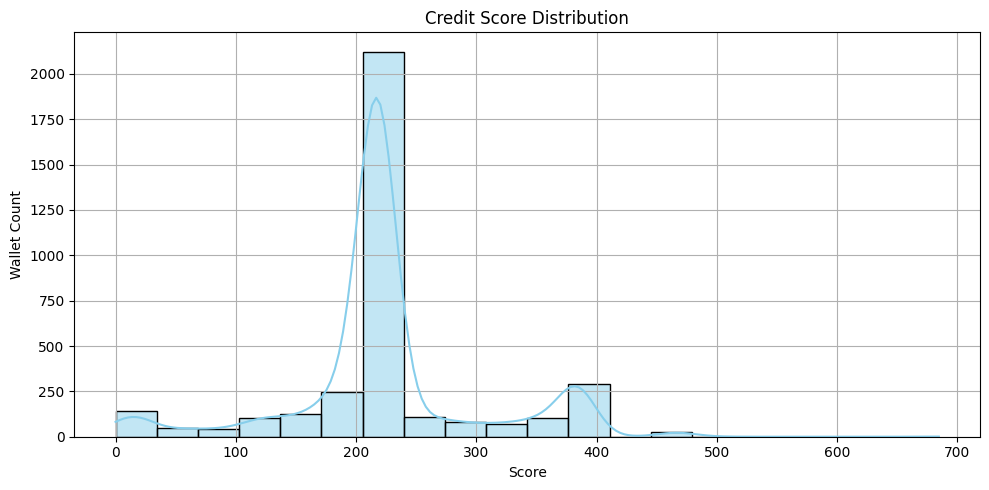

score_distribution_hist.png saved.


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
features_df = pd.read_csv("wallet_features.csv")
scores_df = pd.read_csv("wallet_scores.csv")

# Merge on wallet address
df = features_df.merge(scores_df, on="wallet_address", how="inner")

# Confirm it's present
print("Columns:", df.columns)  # Should include credit_score

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df['credit_score'], bins=20, kde=True, color='skyblue')
plt.title("Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution_hist.png")
plt.show()
plt.close()

print("score_distribution_hist.png saved.")


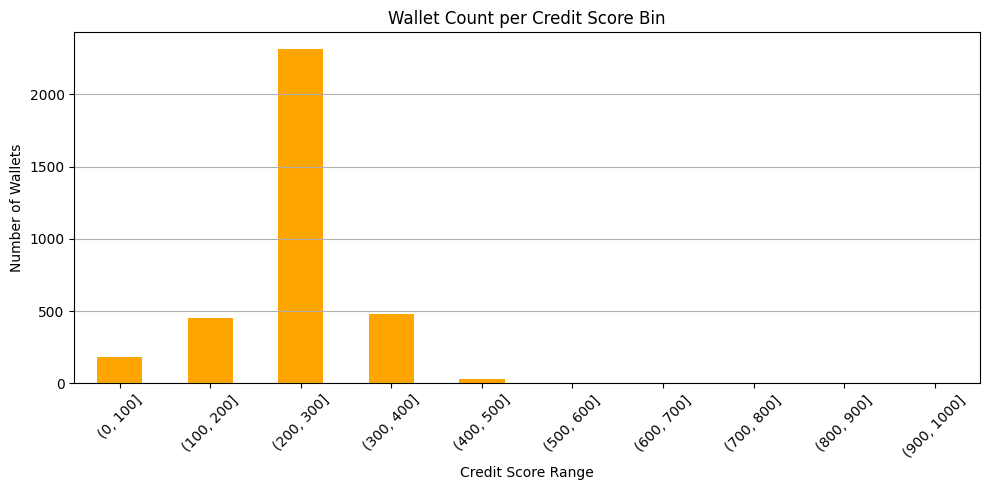

In [89]:
score_bins = pd.cut(df['credit_score'], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
bin_counts = score_bins.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bin_counts.plot(kind='bar', color='orange')
plt.title("Wallet Count per Credit Score Bin")
plt.xlabel("Credit Score Range")
plt.ylabel("Number of Wallets")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("score_bins_bar.png")
plt.show()
plt.close()

C:\Users\Manmita Sahoo\AppData\Local\Temp\ipykernel_5292\4180979739.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.groupby('score_group')[['borrow_deposit_ratio', 'repay_borrow_ratio', 'num_liquidations']].mean()


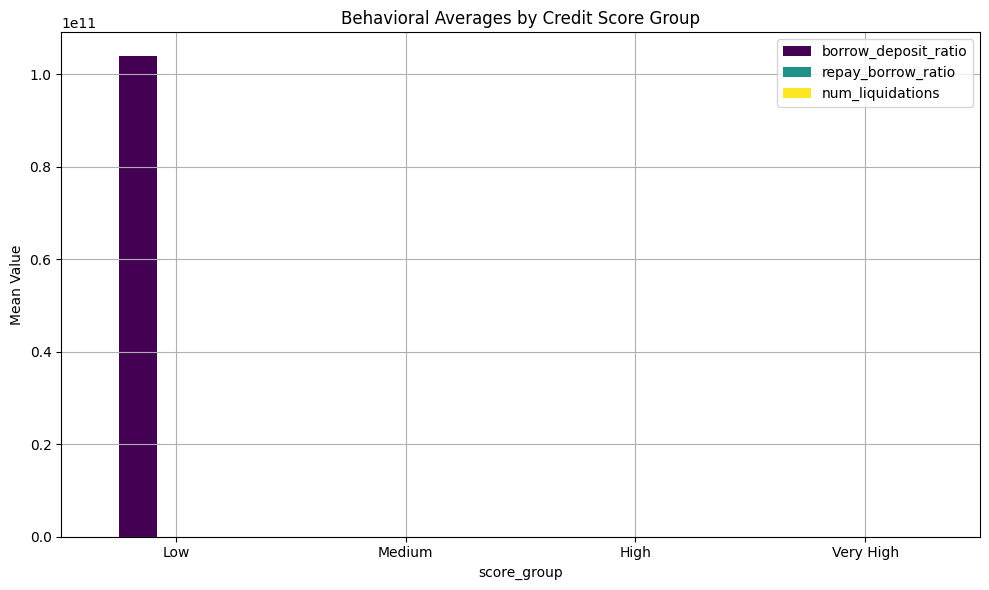

In [90]:
df['score_group'] = pd.cut(df['credit_score'], bins=[0, 300, 600, 800, 1000], labels=["Low", "Medium", "High", "Very High"])

group_means = df.groupby('score_group')[['borrow_deposit_ratio', 'repay_borrow_ratio', 'num_liquidations']].mean()

group_means.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Behavioral Averages by Credit Score Group")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig("score_group_behavior.png")
plt.show()
plt.close()


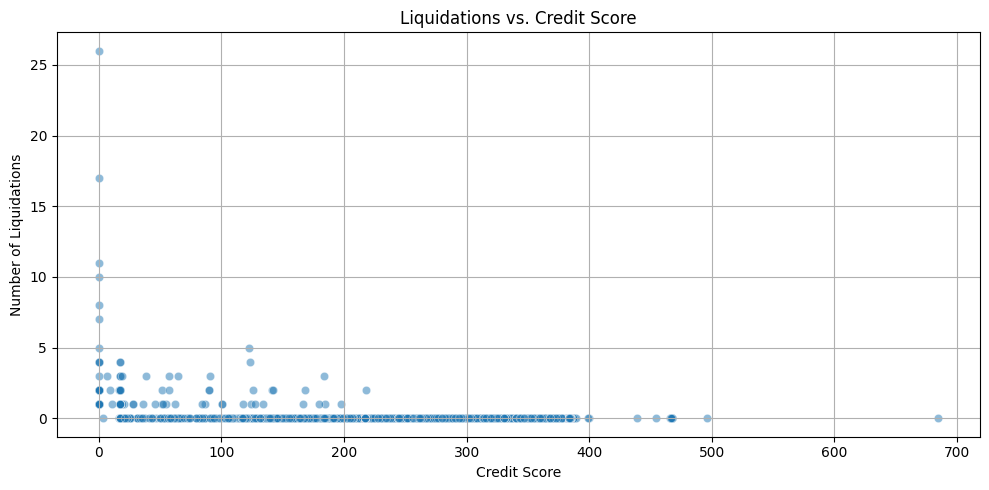

In [91]:
#liquidations vs. score
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='credit_score', y='num_liquidations', alpha=0.5)
plt.title("Liquidations vs. Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Number of Liquidations")
plt.grid(True)
plt.tight_layout()
plt.savefig("liquidations_vs_score.png")
plt.show()
plt.close()

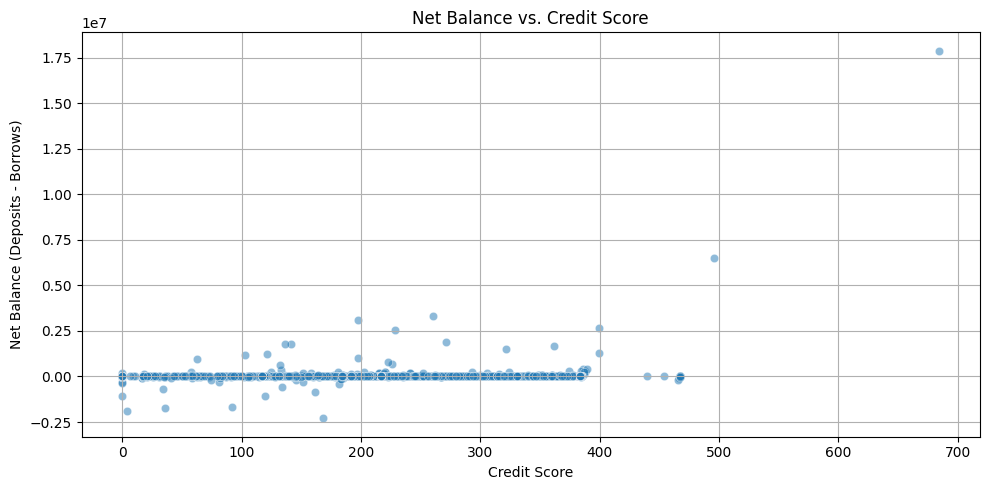

In [92]:
#net balance vs. score
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='credit_score', y='net_balance', alpha=0.5)
plt.title("Net Balance vs. Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Net Balance (Deposits - Borrows)")
plt.grid(True)
plt.tight_layout()
plt.savefig("net_balance_vs_score.png")
plt.show()
plt.close()